# QCoDeS Example with Keysight Infiniium Oscilloscopes
This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight Infinium Oscilloscopes. The driver has been tested with the MSOS104A and MSOS254A.

Please note that the oscilloscopes have plenty of more functions, that have not yet been implemented. Feel free to contribute, request features or report bugs.

In [1]:
%matplotlib inline

### Importing Dependencies

In [2]:
# qcodes imports
import qcodes as qc
from qcodes.dataset import do0d
from qcodes.instrument_drivers.Keysight import KeysightInfiniium

exp = qc.load_or_create_experiment("MSO_Documentation", "no_sample")

### Create the Instrument
please insert the right address of your local scope (TCPIP...) you can find the address with the NI-MAX app or within the network settings of the scope.

In [3]:
mso = KeysightInfiniium("MSO", "TCPIP0::10.1.1.136::inst0::INSTR")

Connected to: KEYSIGHT TECHNOLOGIES MSOS254A (serial:MY57220130, firmware:06.71.00202) in 0.05s


### Prepare Trace
In this example we are going to acquire a 10MHz sine wave at ~8.5dBm from a waveform generator at connected to channel 4 of the scope. Therefore:
 - all the other channels are hidden
 - the time scale is adjusted to measure a few periods of the waveform
 - the time scale is adjusted to have times starting from zero
 - the range of channel four is set to 2.5V.

In [4]:
for i in range(4):
    mso.channels[i].display(False)
mso.ch4.display(True)
mso.timebase_range(0.5e-6)
mso.timebase_position(mso.timebase_range() / 2)
mso.ch4.range(2.5)

#### Trigger Setup
we want to use the input signal itself as the trigger. Therefor the trigger is first enabled, the trigger source is set.

In [5]:
mso.trigger_edge_source("CHAN4")
mso.trigger_edge_slope("NEG")
mso.ch4.trigger_level(0)

#### Data Acquisition
We are going to acquire 5k datapoints and set the sample rate such that the entire waveform is shown on screen. This requires a sample rate of 10Gsps. In addition, we disable interpolation so that the scope only returns 5000 points, rather than interpolating between sampled points.

We also run the trace to verify that it looks correct on the scope.

In [6]:
nPoints = 5000
mso.acquire_points(nPoints)
mso.sample_rate(nPoints / mso.timebase_range())
mso.acquire_interpolate(0)

mso.run()

Then the parameter can be acquired with a qcodes measurement.

Starting experimental run with id: 82. Using 'qcodes.utils.dataset.doNd.do0d'


(results #82@C:\Users\spauka\experiments.db
 ------------------------------------------
 MSO_chan4_time_axis - array
 MSO_chan4_trace - array,
 [<AxesSubplot:title={'center':'Run #82, Experiment MSO_Documentation (no_sample)'}, xlabel='Time (ns)', ylabel='Channel 4 trace (mV)'>],
 [None])

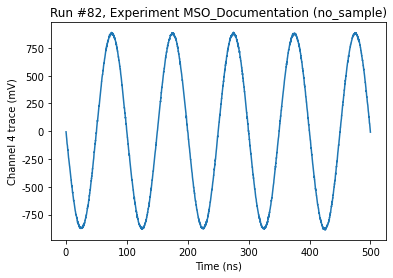

In [7]:
do0d(mso.ch4.trace, do_plot=True)

We can also acquire measurements from the waveform such as the amplitude and the frequency.

In [8]:
ds, _, _ = do0d(mso.ch4.measure.amplitude, mso.ch4.measure.frequency)
df = ds.to_pandas_dataframe()
df

Starting experimental run with id: 83. Using 'qcodes.utils.dataset.doNd.do0d'


,MSO_chan4_measure_amplitude,MSO_chan4_measure_frequency
0,1.74273,10001380.0


## Acquiring Multiple Channels
If we want to acquire multiple channels, we can disable automatic digitization and manually digitize once for each acquisition. To do this, we use the `mso.digitize` function.

In this example, we connect a 1Vpp square wave at 1MHz to ch1, a 1.2Vpp sine wave at 1MHz to ch2 and a 0.5V ramp and 1MHz to ch3.

Starting experimental run with id: 84. Using 'qcodes.utils.dataset.doNd.do0d'


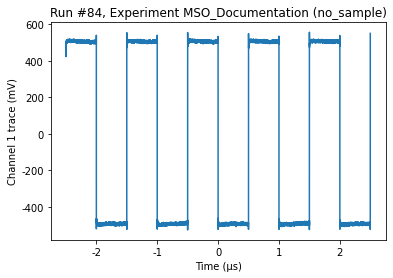

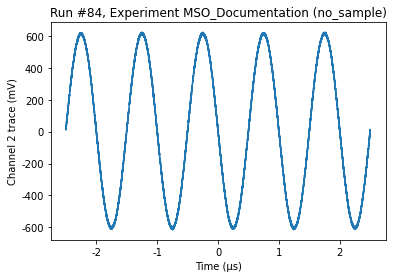

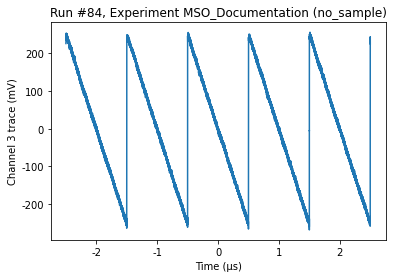

In [9]:
# Disable automatic digitization
mso.auto_digitize(False)

# Set up inputs
for ch in mso.channels[:3]:
    ch.display("on")
    ch.range(2.0)
mso.ch4.display("off")

# Set up timebase
mso.timebase_range(5e-6)
mso.timebase_position(0)
mso.sample_rate(10e9)
mso.acquire_points(50_000)

# Set up trigger
mso.trigger_edge_source("CHAN1")
mso.ch1.trigger_level(0)

# Take the measurement
mso.digitize()
do0d(mso.ch1.trace, mso.ch2.trace, mso.ch3.trace, do_plot=True)

# Set the scope back to free-running mode
mso.run()